In [36]:
### TO-DOs ###

# Plot the historical and projected trajectory with confidence intervals for each input
# Prepare this to be repeated at any point during the year and not just at year end (ttm calculations, etc.)

In [69]:
import requests
from urllib.parse import urlparse, urlunparse

import numpy as np
import numpy_financial as npf

import scipy as sp 
#from scipy.stats import norm

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import yfinance as yf

from datetime import date

from itertools import accumulate
import operator


#financialmodellingprep.com API key
apikey = '6d5a44e82d49d8446e8db1914d12e2b4'
simfinkey = 'S54dNEScw70KAegQwNs46skHPfblWSoB'

In [14]:
hist_df = pd.read_excel('data/histimplERP.xls',sheet_name='Historical Impl Premiums',header=6,skipfooter=7)
hist_df.drop(hist_df.tail(1).index,inplace=True) #Temporary fix because using data file from 2021 and replicating valuation as if it was 2020

In [15]:
valuation_date = date.fromisoformat('2020-06-01')
years_to_project = 5

monte_carlo_iterations = 5000

projected_years = [y for y in range(valuation_date.year,valuation_date.year+years_to_project)]
# Instead of years the dates should be 12 months from valuation date, and then 12 months later, etc.

## S&P500 Valuation
21 February 2021

#### Framework and key questions to answer
<img src="img/IndexValueFramework.jpg" width=360 align="left"/>

#### Story

---

**1. Earnings Growth**: 
- 2020 will be a very bad year for companies in the index that will see a reduction in earnings of c.30% (in the 2% of the worst in the last 50 years)
- Earnings will recover in 2021 (c.25% growth) but wont reach 2019 levels until 2022
- From 2022 onwards earnings will grow at the average rate of the last 20 years (c. 7% p.a.)

**2. Cash Return**

**3. Risk Premium**

**4. Risk Free Rate**

### Calculations

In [87]:
inputs_df = pd.DataFrame()
inputs_df['year'] = hist_df['Year']
inputs_df['ERP'] = hist_df['Implied Premium (FCFE)']
inputs_df['earnings'] = hist_df['Earnings*']
inputs_df['RFR'] = hist_df['T.Bond Rate']
inputs_df['div&bb'] = hist_df['Dividends + Buybacks']

In [88]:
# Original Damodaran estimates
#   future_earnings = np.array([120.0,150.0,160.83,172.45,184.91])
#      earnings_first_year = 120.0
#      earnings_growth = np.array([0.25,0.0722,0.0722,0.0722])

#   cash_returned = np.array([90.71,121.01,137.93,156.66,177.37])
#   cash_returned_percent = np.array([0.75591667, 0.80673333, 0.85761363, 0.90843723, 0.95922341])
#      percent_returned_first = 0.7559  # INTRODUCE RANDOMNESS
#      percent_returned_last = 0.9593   # INTRODUCE RANDOMNESS

#   equity_risk_premium = 5.58/100
#      ERP_random = np.repeat(5.58/100,monte_carlo_iterations)

outputs_df = pd.DataFrame()

# Generate all the rndom variables at once to then use inside the iteration
earnings_first_year_random = sp.stats.norm.rvs(loc=120,scale=10,size=monte_carlo_iterations)
earnings_growth_random = [sp.stats.norm.rvs(loc=7.04/100,scale=16/100,size=years_to_project-1) for year in range(0,monte_carlo_iterations)]    
first_year_growth_override = sp.stats.norm.rvs(loc=0.25,scale=0.05,size=monte_carlo_iterations) # None means not to override

ERP_random = np.random.uniform(5.02/100,6.14/100,monte_carlo_iterations)
#ERP_random = np.repeat(5.58/100,monte_carlo_iterations)

percent_returned_first_random = sp.stats.norm.rvs(loc=0.7559,scale=0.1,size=monte_carlo_iterations)
percent_returned_last_random = sp.stats.norm.rvs(loc=0.9593,scale=0.1,size=monte_carlo_iterations)

risk_free_rate_random = np.repeat(0.66/100,monte_carlo_iterations)

# What is below would be one iteration
for i in range(0,monte_carlo_iterations):

    earnings_first_year = earnings_first_year_random[i]
    earnings_growth = earnings_growth_random[i]
    if first_year_growth_override is not None:
        earnings_growth[0] = first_year_growth_override[i]
    growth_factor = [1] + list(accumulate(earnings_growth+1, operator.mul))
    future_earnings = np.repeat(earnings_first_year, years_to_project) * growth_factor

    percent_returned_first = percent_returned_first_random[i]
    percent_returned_last = percent_returned_last_random[i]
    percent_returned = np.linspace (start=percent_returned_first,stop=percent_returned_last,num=years_to_project)
    cash_returned = future_earnings * percent_returned 

    equity_risk_premium = ERP_random[i]
    
    risk_free_rate = risk_free_rate_random[i]

    # Calculate the discount rate
    discount_rate = risk_free_rate + 1 * equity_risk_premium
    long_term_growth = risk_free_rate

    #Calculate intrinsic value of the index given estimates for input
    cash_flows = np.concatenate((np.array([0]),cash_returned)) # Add a "today" cash flow of 0 to make first cash flow in year 1
    cash_terminal = cash_returned[-1]*(1+long_term_growth)/(discount_rate - long_term_growth)
    cash_flows[-1] += cash_terminal

    intrinsic_index_level = npf.npv(discount_rate,cash_flows)
    d = [{'S&P500': intrinsic_index_level}]
    outputs_df = outputs_df.append(d,ignore_index=True,sort=False)

    # Create rows for projection
    d = {'year': projected_years, 
         'earnings': future_earnings,
         'div&bb': cash_returned,
         'RFR': [risk_free_rate]*years_to_project,
         'ERP': [equity_risk_premium]*years_to_project,
        }
    temp_df = pd.DataFrame(d)
    
    # Append new projection to output_df
    inputs_df = pd.concat([inputs_df,temp_df])

### Assumptions and story

In [89]:
ref_period_years = 20
initial_year = projected_years[0] - ref_period_years
historical_mask = (inputs_df['year']<projected_years[0])&(inputs_df['year']>=initial_year)
projected_mask = (inputs_df['year']>=projected_years[0])&(inputs_df['year']<=projected_years[-1])

In [90]:
inputs_df['% earnings returned'] = inputs_df['div&bb']/inputs_df['earnings']

In [151]:
column = 'RFR'
column_yoy = column+' growth'


In [146]:
inputs_df[column_yoy] = inputs_df[column].pct_change()

Text(-10, 5, '0')

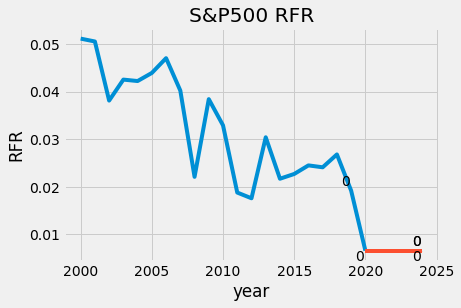

In [152]:
hist_mask_chart = (inputs_df['year']<=projected_years[0])&(inputs_df['year']>=initial_year)

ax = sns.lineplot(x="year", 
                  y=column,
                  data=inputs_df[hist_mask_chart])
ax = sns.lineplot(x="year", 
                  y=column,
                  data=inputs_df[projected_mask],
                  ci="sd")
ax.set_title('S&P500 '+column)

last_historic_value = inputs_df[inputs_df['year']==projected_years[0]-1][column].mean()
first_projected_value = inputs_df[inputs_df['year']==projected_years[0]][column].mean()
last_projected_value = inputs_df[inputs_df['year']==projected_years[-1]][column].mean()
bottom_ci_value = inputs_df[inputs_df['year']==projected_years[-1]][column].mean()-inputs_df[inputs_df['year']==projected_years[-1]][column].std()
top_ci_value = inputs_df[inputs_df['year']==projected_years[-1]][column].mean()+inputs_df[inputs_df['year']==projected_years[-1]][column].std()

ax.annotate(text=f'{last_historic_value:.0f}',
            xy = (projected_years[0]-1,last_historic_value),
            xytext = (-10,5),textcoords='offset points')
ax.annotate(text=f'{first_projected_value:.0f}',
            xy = (projected_years[0],first_projected_value),
            xytext = (-10,-10),textcoords='offset points')
ax.annotate(text=f'{last_projected_value:.0f}',
            xy = (projected_years[-1],last_projected_value),
            xytext = (-10,5),textcoords='offset points')
ax.annotate(text=f'{bottom_ci_value:.0f}',
            xy = (projected_years[-1],bottom_ci_value),
            xytext = (-10,-10),textcoords='offset points')
ax.annotate(text=f'{top_ci_value:.0f}',
            xy = (projected_years[-1],top_ci_value),
            xytext = (-10,5),textcoords='offset points')

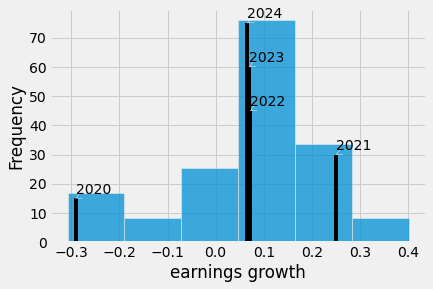

In [148]:
ax = sns.histplot(data=inputs_df[historical_mask], x=column_yoy,stat="frequency")
#sns.histplot(data=inputs_df[projected_mask], x=column_yoy,stat="density",hue='year',ax=ax)
for count,year in enumerate(projected_years):
    growth = inputs_df[inputs_df['year']==year][column_yoy].mean()
    height = 15*(count+1)
    ax.vlines(growth, 0, height, colors='k', linestyles='solid', label='XX')
    ax.annotate(text=f'{year}',
                xy=(growth,height),
                xytext=(0,5),
                textcoords='offset points',
                arrowprops={'arrowstyle':'->'})

In [10]:
growth = inputs_df[inputs_df['year']==projected_years[0]]['earnings growth'].mean()
sp.stats.percentileofscore(inputs_df[historical_mask]['earnings growth'],growth)

1.694915254237288

In [11]:
inputs_df[~historical_mask].corr()

,year,ERP,earnings,RFR,div&bb,earnings growth
year,1.000000,0.000000e+00,0.547122,-2.671868e-01,6.760979e-01,3.261600e-01
ERP,0.000000,1.000000e+00,-0.003532,1.431632e-13,2.209835e-03,3.588683e-03
earnings,0.547122,-3.531509e-03,1.000000,-2.588231e-02,9.261959e-01,5.628688e-01
RFR,-0.267187,1.431632e-13,-0.025882,1.000000e+00,-2.141895e-14,2.301043e-16
div&bb,0.676098,2.209835e-03,0.926196,-2.141895e-14,1.000000e+00,4.980731e-01
earnings growth,0.326160,3.588683e-03,0.562869,2.301043e-16,4.980731e-01,1.000000e+00


### Results

### OUT

In [55]:
inputs_df[(inputs_df['year']==2021)].describe()

,year,earnings,div&bb,RFR,ERP
count,1000.0,1000.000000,1000.000000,1.000000e+03,1000.000000
mean,2021.0,149.908555,121.247984,6.600000e-03,0.055704
std,0.0,6.224580,13.066997,1.735591e-18,0.003285
min,2021.0,129.877773,82.142502,6.600000e-03,0.050201
25%,2021.0,145.554064,112.639330,6.600000e-03,0.052725
50%,2021.0,149.802659,120.772510,6.600000e-03,0.055724
75%,2021.0,154.214893,129.724080,6.600000e-03,0.058571
max,2021.0,169.140317,166.209889,6.600000e-03,0.061378


<AxesSubplot:xlabel='year', ylabel='div&bb'>

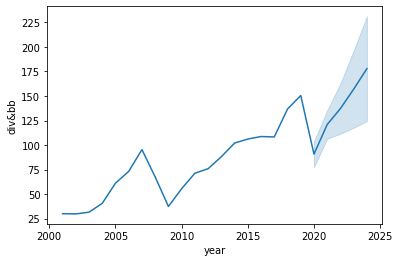

<AxesSubplot:ylabel='S&P500'>

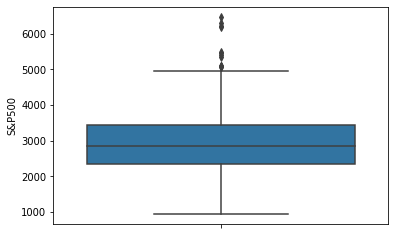

In [70]:
sns.boxplot(y="S&P500",
            data=outputs_df)

<AxesSubplot:xlabel='S&P500', ylabel='Count'>

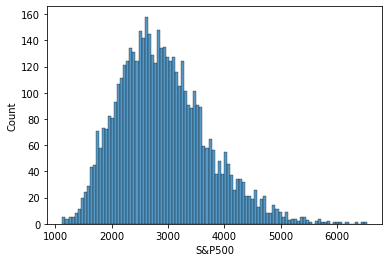

In [148]:
sns.histplot(data=outputs_df, x="S&P500", bins=100)

In [47]:
outputs_df['S&P500'].quantile(np.linspace(.1, 1, 9, 0))

0.1    1999.545417
0.2    2244.394199
0.3    2443.494140
0.4    2645.003773
0.5    2821.716431
0.6    3014.906782
0.7    3255.562276
0.8    3539.090190
0.9    3972.912596
Name: S&P500, dtype: float64

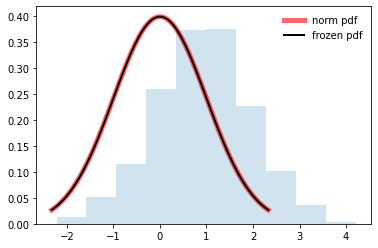

In [34]:
from scipy.stats import norm

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)

mean, var, skew, kurt = norm.stats(moments='mvsk')

x = np.linspace(norm.ppf(0.01),norm.ppf(0.99), 100)
ax.plot(x, norm.pdf(x),'r-', lw=5, alpha=0.6, label='norm pdf')

rv = norm()
ax.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')

vals = norm.ppf([0.001, 0.5, 0.999])
np.allclose([0.001, 0.5, 0.999], norm.cdf(vals))

r = norm.rvs(loc=1,scale=1,size=1000)

ax.hist(r, density=True, histtype='stepfilled', alpha=0.2)
ax.legend(loc='best', frameon=False)
plt.show()

In [55]:
#for year in range(0,years_to_project):
#    r = norm.rvs(loc=1,scale=1,size=monte_carlo_iterations)

    
t = [norm.rvs(loc=1,scale=1,size=years_to_project) for year in range(0,monte_carlo_iterations)]    

In [60]:
t[10]
#earnings_growth

array([ 1.97333188,  2.49999924,  1.39833037, -0.24420663,  2.02744035])

In [13]:
sp.stats.norm.rvs()

1.1323459615773566